## Multi-dimensional GP

In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import plotly.express as px
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
np.random.seed(42)

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%config InlineBackend.figure_format = 'retina'
 
plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
#'lines.linewidth' : 3,
#'lines.markersize' : 10,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
plt.rcParams.update(plot_params)

In [3]:
#Define a objective function -- in real case we have this a 'black-box'
def f(X, f_noise):
    return  X * np.sin(X) + f_noise * np.random.randn(*X.shape) 

def rosenbrack(x,y):
    f = (1 - x)**2 - 100 * (y - x**2)**2
    return -1 * f

def test(x,y):
    f = (1 - x)**2 + (y**2)
    return -1 * f

noise = 0.1
bounds = np.array([[-2.0, 2.0],[-3.0, 4.0]])
# Dense grid of points within bounds
dim1_bounds = np.linspace(bounds[:, 0][0], bounds[:, 1][0], 1000).reshape(-1,1)
dim2_bounds = np.linspace(bounds[:, 0][1], bounds[:, 1][1], 1000).reshape(-1,1)

In [4]:
X_total = np.vstack((dim1_bounds.T, dim2_bounds.T)).T
(X1X1_total, X2X2_total) = np.meshgrid(X_total[:,0], X_total[:,1], sparse=True)
Z_total = rosenbrack(X1X1_total,X2X2_total)

In [36]:
#Create initial samples 
random_indices_X1 = np.random.choice(len(X_total[:,0]),size=100, replace=False)
random_indices_X2 = np.random.choice(len(X_total[:,1]),size=100, replace=False)
X_init = np.vstack((X_total[:,0][random_indices_X1].T, X_total[:,1][random_indices_X2].T)).T
Z_init = rosenbrack(X_init[:,0], X_init[:,1])

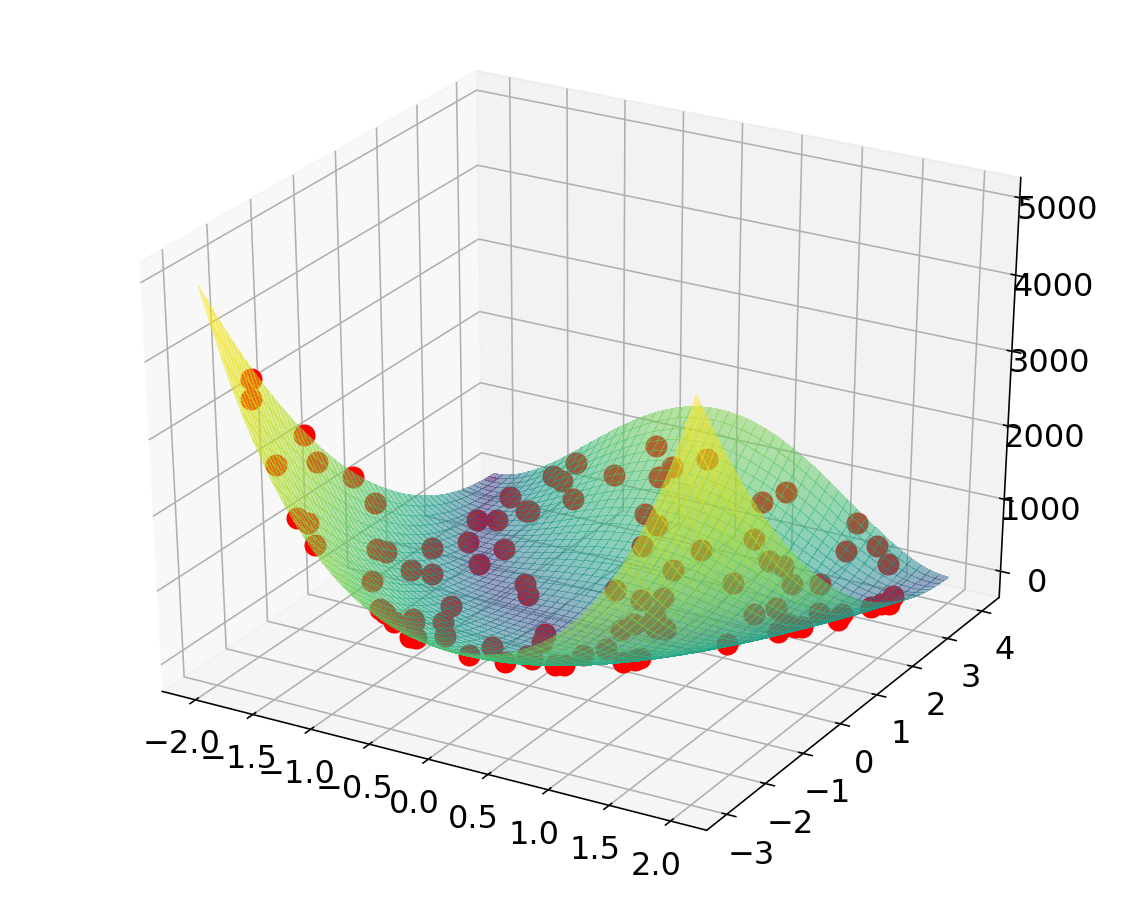

In [37]:
# Plot optimization objective with noise level 
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_init[:,0], X_init[:,1], Z_init, c='r', marker='o', s=100, depthshade=False)
ax.plot_surface(X1X1_total, X2X2_total, Z_total, cmap=cm.viridis, linewidth=0, alpha=0.5, antialiased=False, norm=colors.PowerNorm(gamma=0.2))

In [38]:
#Test-train split 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
X_train, X_test, Z_train, Z_test = train_test_split(X_init, Z_init, test_size=0.33, random_state=42)

In [39]:
#Gaussian process with Matern kernel as surrogate model 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF 
cMatern_kernel = ConstantKernel(1.0) * Matern(length_scale=[1.0,5.0], nu=2.5) #Length-scale and nu=deviation from RBF
cRBF = ConstantKernel(1.0, (1e-2, 1e1)) * RBF((1e-0, 1e1), (1e-0, 1e1))
'''
Constant kernel: used as part of a product-kernel where it scales the magnitude of 
the other factor (usually a kernel)
'''

'\nConstant kernel: used as part of a product-kernel where it scales the magnitude of \nthe other factor (usually a kernel)\n'

In [40]:
gpr = GaussianProcessRegressor(kernel=cRBF, alpha=1e-2, n_restarts_optimizer=20, normalize_y=True, random_state=42)

In [41]:
gpr.fit(X_train, Z_train.reshape(-1,1))

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=[1, 10]),
                         n_restarts_optimizer=20, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=42)

In [42]:
pred_mu, pred_std = gpr.predict(X_test, return_std=True)
std_err = 1.96 * pred_std

In [43]:
mae = mean_absolute_error(Z_test, pred_mu)
rmse = np.sqrt(mean_squared_error(Z_test, pred_mu))
r2 = r2_score(Z_test, pred_mu)
print(
"""mae = {}
rmse = {}
r2 = {}"""
.format(mae, rmse, r2))

mae = 62.47725177955514
rmse = 105.88035481291851
r2 = 0.9831564375556956


No handles with labels found to put in legend.


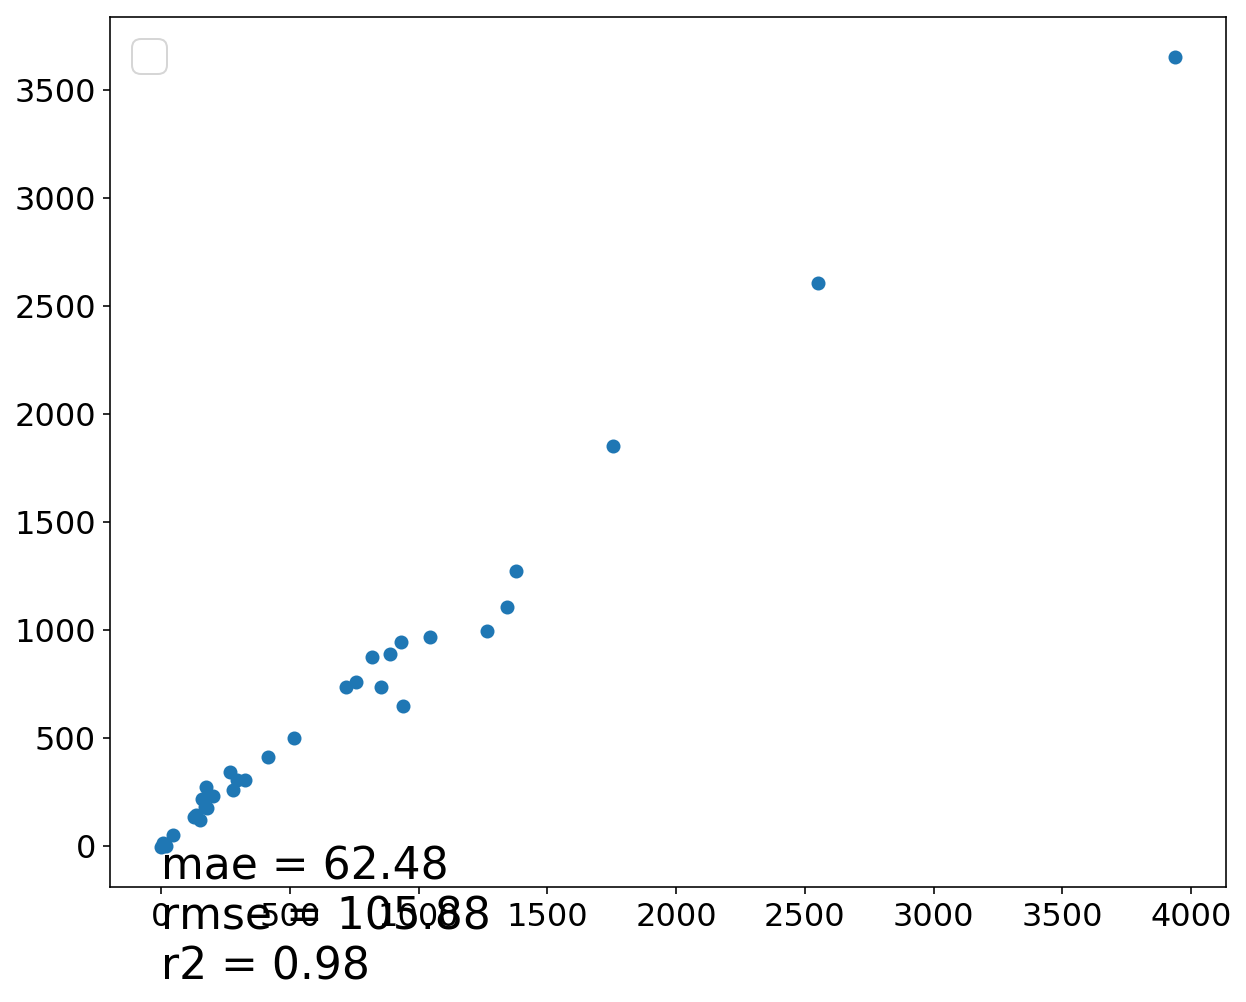

In [50]:
fig, ax = plt.subplots(figsize=(10,8))
#ax.scatter(Z_test, pred_mu)
ax.errorbar(Y_test, pred_mu, yerr=1.96 * pred_std, fmt='o')
text = (
"""mae = {:0.2f}
rmse = {:0.2f}
r2 = {:0.2f}"""
.format(mae, rmse, r2))
ax.set_ylabel('Predicted mean Y')
ax.set_xlabel('f(x1, x2)')
plt.text(x=1.0, y=max(pred_mu)-10, s=text, horizontalalignment='left',verticalalignment='top')
plt.tight_layout()